* Check why damier effect on mask prediction

In [1]:
import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence

from src.commons.utils import *
from src.models.commons.mask_process import extract_object_from_batch, binarize_mask
from src.commons.constants import IMG_SIZE
from src.data.process import generate_grid_prompt

In [2]:
from src.commons.utils_io import load_sam
from src.models.commons.bisam import BiSam2, SamModeInference
from src.models.segment_any_change.model import BiSam

In [3]:
def show_prompts_on_mask(mask: torch.Tensor, batch, batch_idx: int):
    if mask.shape[-1] != IMG_SIZE[0]:
        mask = resize(mask, IMG_SIZE)
    coord_points = batch["point_coords"][batch_idx]
    mask_pt = get_mask_with_prompt(binarize_mask(mask[batch_idx], th=0) , coord_points)
    show_img(mask_pt)

### Load model

In [9]:
bisam_raw = load_sam(
    model_type="vit_b", model_cls=BiSam2, version= "dev2", device="cpu"
)

2024-07-31 12:05:54,449 - INFO ::  build vit_b BiSam2


In [5]:
bisam = load_sam(
    model_type="vit_b", model_cls=BiSam, version= "dev", device="cpu"
)

2024-07-31 12:04:13,093 - INFO ::  build vit_b BiSam


### Load dloader manually

In [6]:
from src.data.loader import BiTemporalDataset
from src.data.process import DefaultTransform
from omegaconf import OmegaConf

params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "n_shape":3,
    "loc": "center",
    "batch_size": 2,
}
ds = BiTemporalDataset(
            name="levir-cd",
            dtype="train",
            transform=DefaultTransform(),
            params=OmegaConf.create(params),
        )

In [7]:
dloader = data.DataLoader(
            ds,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
        )

In [8]:
batch = next(iter(dloader))

* est ce que l'on a un effet de damier sur les prediction du bisam de SeAnyChange ? i.e la version batchée 

#### Batch version

In [11]:
out_bisam = bisam(batch,
                multimask_output=False,
                mode=SamModeInference.INTERACTIVE)

sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])


In [12]:
masks_bisam = out_bisam["masks"]

In [13]:
masks_bisam.shape

torch.Size([2, 3, 1, 256, 256])

In [14]:
masks_bisam = torch.sum(masks_bisam, dim=1).squeeze()

In [15]:
masks_bisam.shape

torch.Size([2, 256, 256])

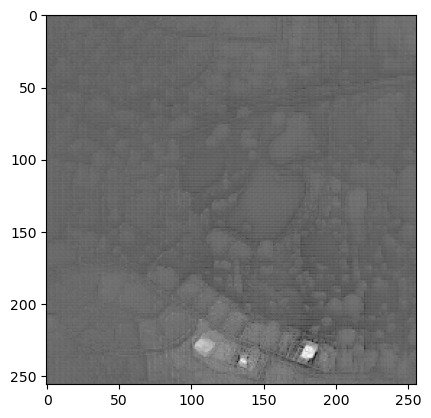

In [21]:
plt.imshow(shift_range_values(masks_bisam[0]), cmap="Greys_r")

#### Raw version (bisam)

In [10]:
out_bisam_raw = bisam_raw(batch,
                multimask_output=False,
                mode=SamModeInference.INTERACTIVE)

patch embed : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
In attn block : torch.Size([2, 64, 64, 768])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


In [18]:
masks_bisam_raw = out_bisam_raw["masks"].detach()

In [19]:
masks_bisam_raw.shape

torch.Size([2, 1, 1, 256, 256])

In [20]:
masks_bisam_raw = torch.sum(masks_bisam_raw, dim=1).squeeze()

In [21]:
masks_bisam_raw.shape

torch.Size([2, 256, 256])

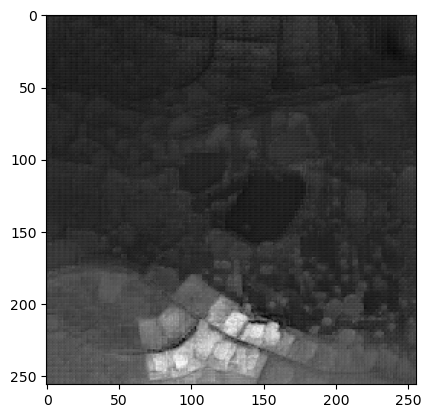

In [22]:
plt.imshow(shift_range_values(masks_bisam_raw[0]), cmap="Greys_r")

### Check with original predictor

In [23]:
from src.models.segment_anything import sam_model_registry_ori, SamPredictor
from src.commons.constants import SAM_MODEL_SMALL_PATH

device = "cpu"
model_type = "vit_b"

sam = sam_model_registry_ori[model_type](checkpoint=SAM_MODEL_SMALL_PATH)
sam.to(device=device)

predictor = SamPredictor(sam)

2024-07-31 13:06:37,317 - INFO ::  build SAM


In [26]:
%%time
image= to_numpy(batch["img_B"][0]).astype(np.uint8)
predictor.set_image(image)

patch embed : torch.Size([1, 64, 64, 768])
In attn block : torch.Size([1, 64, 64, 768])
In attn block : torch.Size([1, 64, 64, 768])
In attn block : torch.Size([1, 64, 64, 768])
In attn block : torch.Size([1, 64, 64, 768])
In attn block : torch.Size([1, 64, 64, 768])
In attn block : torch.Size([1, 64, 64, 768])
In attn block : torch.Size([1, 64, 64, 768])
In attn block : torch.Size([1, 64, 64, 768])
In attn block : torch.Size([1, 64, 64, 768])
In attn block : torch.Size([1, 64, 64, 768])
In attn block : torch.Size([1, 64, 64, 768])
In attn block : torch.Size([1, 64, 64, 768])
CPU times: user 2min 1s, sys: 12 s, total: 2min 13s
Wall time: 5.14 s


In [27]:
batch["point_coords"]

tensor([[[519., 851.],
         [580., 881.],
         [364., 960.]],

        [[505., 376.],
         [470., 468.],
         [488., 632.]]])

In [30]:
input_point = to_numpy(batch["point_coords"][0],  transpose=False)
input_label = to_numpy(batch["point_labels"][0], transpose=False)

In [32]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=None,
    multimask_output=False,
    return_logits=True
)

sparse emb : torch.Size([1, 4, 256])
dense emb : torch.Size([1, 256, 64, 64])
low mask  predict torch : torch.Size([1, 1, 256, 256])
low mask  predict torch : torch.Size([1, 1, 1024, 1024])


In [33]:
masks.shape

(1, 1024, 1024)

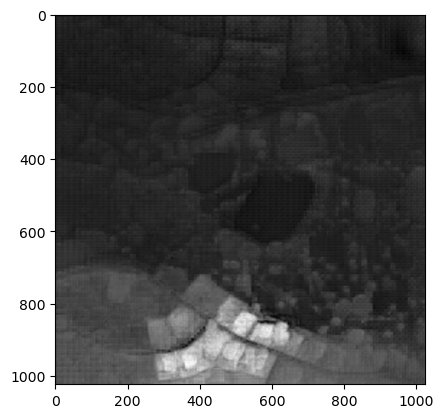

In [34]:
plt.imshow(masks.squeeze(), cmap="Greys_r")

### Try with no prompt

In [35]:
out_bisam = bisam(batch,
                multimask_output=False,
                mode=SamModeInference.INTERACTIVE)

sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])


In [36]:
image_embeddings = bisam.image_embeddings

In [42]:
batch["point_coords"].shape

torch.Size([2, 3, 2])

In [205]:
batch["point_labels"].shape

torch.Size([2, 3])

In [219]:
no_pts = torch.zeros((2, 3, 2)) -1000

In [220]:
no_pts

tensor([[[-1000., -1000.],
         [-1000., -1000.],
         [-1000., -1000.]],

        [[-1000., -1000.],
         [-1000., -1000.],
         [-1000., -1000.]]])

In [238]:
no_pts_label = torch.zeros(no_pts.shape[:2]) #-1

In [239]:
no_pts_label.shape

torch.Size([2, 3])

In [240]:
point_labels.shape

torch.Size([2, 3])

In [241]:
#point_coords = no_pts

In [267]:
# remove padding points
point_labels = batch["point_labels"]

sparse_embeddings, dense_embeddings = bisam.prompt_encoder(
    points=(
        batch["point_coords"][:,None,...],
        no_pts_label[:, None,...],
    ), 
    boxes=None,
    masks=None,
)

low_res_masks, iou_predictions =  bisam.mask_decoder.predict_masks_batch(
    image_embeddings=image_embeddings,  # (B, 256, 64, 64)
    image_pe=bisam.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
    sparse_prompt_embeddings=sparse_embeddings,  # (B, N, 2, 256)
    dense_prompt_embeddings=dense_embeddings,  # (B, N, 256, 64, 64)
)

preds, iou_predictions = bisam.select_masks(
    low_res_masks, 
    iou_predictions, 
    multimask_output=False
)

In [268]:
preds = preds.detach().squeeze()

In [269]:
preds

tensor([[[-2.8514, -4.9314, -4.9183,  ..., -4.3156, -5.0653, -3.1278],
         [-4.5868, -8.1004, -5.9214,  ..., -6.3501, -5.1907, -4.3060],
         [-4.4062, -4.6528, -4.0541,  ..., -4.9481, -5.3831, -3.3381],
         ...,
         [-3.8528, -4.1172, -3.7250,  ..., -5.2704, -5.3811, -3.8834],
         [-3.9370, -5.6472, -4.7189,  ..., -5.7527, -6.5804, -3.4085],
         [-3.8577, -4.6165, -3.8640,  ..., -5.4642, -5.5193, -4.0758]],

        [[-0.6846, -1.0541, -0.7858,  ..., -0.9677, -1.0254, -1.0431],
         [-0.9048, -1.0530, -1.1140,  ..., -1.0383, -1.0249, -0.8680],
         [-0.9163, -1.2064, -0.9317,  ..., -1.1310, -1.1812, -1.2375],
         ...,
         [-1.0195, -1.0603, -1.1606,  ..., -0.6826, -1.0242, -0.5955],
         [-1.0032, -1.1102, -1.2744,  ..., -0.5605, -1.0482, -0.5000],
         [-1.1911, -1.1599, -1.5552,  ..., -0.7738, -1.0166, -0.6909]]])

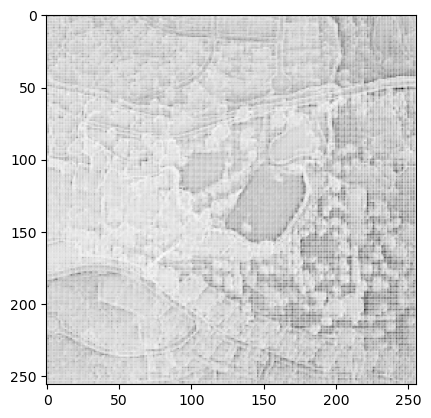

In [270]:
plt.imshow(preds[0].detach(), cmap="Greys_r")

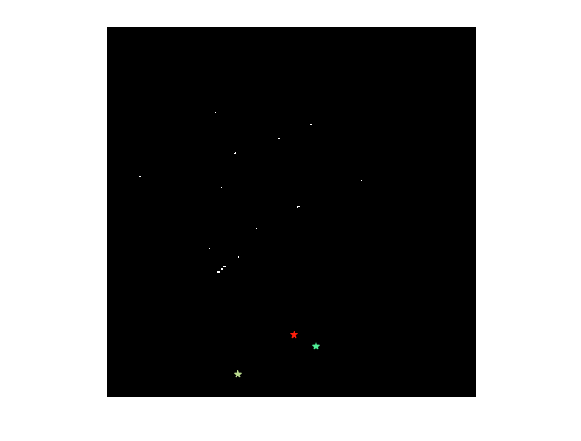

In [271]:
show_prompts_on_mask(preds, batch, 0)

In [258]:
preds[0].detach().shape

torch.Size([256, 256])

In [262]:
preds[0].shape

torch.Size([256, 256])

In [264]:
from src.commons.utils import resize
res = resize(preds, (1024, 1024))

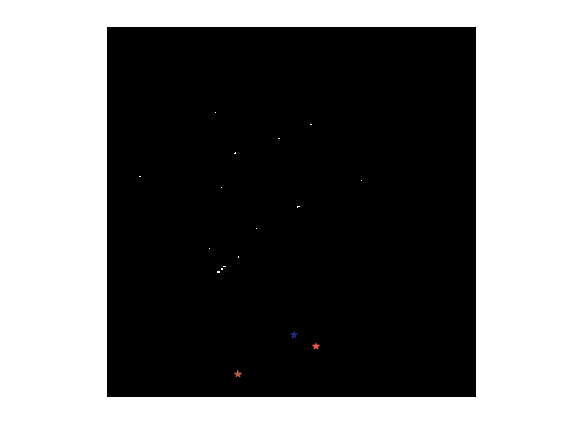

In [265]:
show_prompts_on_mask(res, batch, 0)

In [255]:
preds[1]

tensor([[-0.6846, -1.0541, -0.7858,  ..., -0.9677, -1.0254, -1.0431],
        [-0.9048, -1.0530, -1.1140,  ..., -1.0383, -1.0249, -0.8680],
        [-0.9163, -1.2064, -0.9317,  ..., -1.1310, -1.1812, -1.2375],
        ...,
        [-1.0195, -1.0603, -1.1606,  ..., -0.6826, -1.0242, -0.5955],
        [-1.0032, -1.1102, -1.2744,  ..., -0.5605, -1.0482, -0.5000],
        [-1.1911, -1.1599, -1.5552,  ..., -0.7738, -1.0166, -0.6909]])

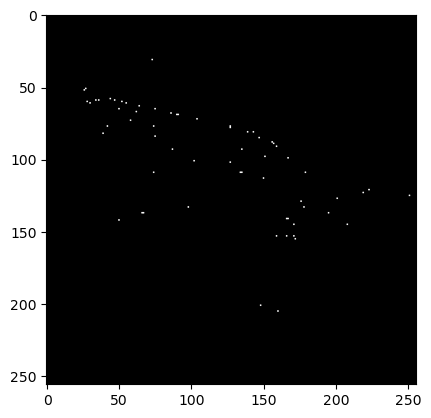

In [254]:
plt.imshow(preds[1].detach() > 0, cmap="Greys_r")

In [246]:
sparse_embeddings.shape

torch.Size([2, 1, 4, 256])

In [153]:
from copy import deepcopy

In [272]:
sparse_none = deepcopy(sparse_embeddings[0][-1].unsqueeze(-1).detach().numpy().squeeze())

In [154]:
sparse = deepcopy(sparse_embeddings[0][-1].unsqueeze(-1).detach().numpy().squeeze())

In [175]:
sparse[:5]

array([[ 0.71041995,  1.0730321 , -0.76920545, ..., -0.04023221,
        -1.0862914 ,  0.75297076],
       [ 0.9374885 ,  0.94943786, -0.8723596 , ..., -0.18745092,
        -0.80738395, -0.21529429],
       [ 0.96365327,  0.42329386,  0.9866257 , ..., -0.5420296 ,
         0.6519148 , -0.17554209],
       [-0.02181001,  0.06549171, -0.08218097, ...,  0.07601959,
         0.19085777, -0.15610085]], dtype=float32)

In [163]:
sparse_0 = deepcopy(sparse_embeddings[0][-1].unsqueeze(-1).detach().numpy().squeeze())

In [164]:
sparse_0[:5]

array([[ 0.2386992 ,  1.106925  , -0.9154866 , ..., -0.7247045 ,
        -0.54686147, -0.21198484],
       [ 0.2386992 ,  1.106925  , -0.9154866 , ..., -0.7247045 ,
        -0.54686147, -0.21198484],
       [ 0.2386992 ,  1.106925  , -0.9154866 , ..., -0.7247045 ,
        -0.54686147, -0.21198484],
       [-0.02181001,  0.06549171, -0.08218097, ...,  0.07601959,
         0.19085777, -0.15610085]], dtype=float32)

In [173]:
sparse_neg1000 = deepcopy(sparse_embeddings[0][-1].unsqueeze(-1).detach().numpy().squeeze())

In [174]:
sparse_neg1000[:5]

array([[ 0.40992188, -0.8679754 , -0.12573051, ...,  0.24217883,
         0.7647013 , -0.06718162],
       [ 0.40992188, -0.8679754 , -0.12573051, ...,  0.24217883,
         0.7647013 , -0.06718162],
       [ 0.40992188, -0.8679754 , -0.12573051, ...,  0.24217883,
         0.7647013 , -0.06718162],
       [-0.02181001,  0.06549171, -0.08218097, ...,  0.07601959,
         0.19085777, -0.15610085]], dtype=float32)

In [138]:
sparse_neg1000.shape

torch.Size([4, 256])

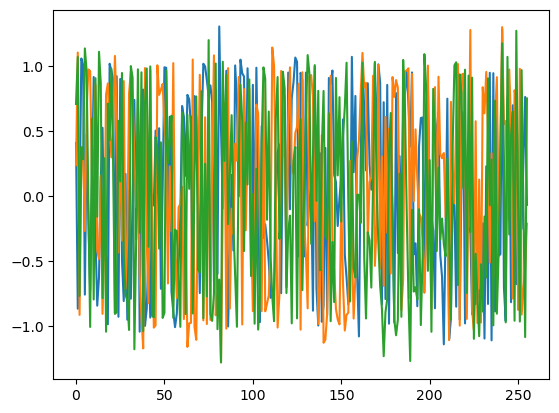

In [179]:
_=plt.plot(sparse_neg1000[0])
_=plt.plot(sparse_0[0])
_=plt.plot(sparse[0])

Text(0.5, 1.0, "Distribution de l'embedding du prompt (points) selon les coordonnées d'entrée")

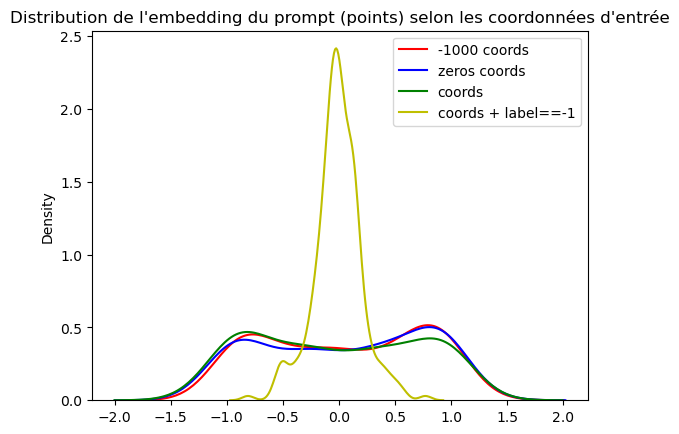

In [277]:
neg1000 = pd.Series(sparse_neg1000[0])
zeros = pd.Series(sparse_0[0])
points = pd.Series(sparse[0])

fig, ax = plt.subplots()
sns.distplot(neg1000, kde=True, hist=False, ax=ax, color="r", label="-1000 coords")
sns.distplot(zeros, kde=True, hist=False , ax=ax, color="b", label="zeros coords")
sns.distplot(sparse[0], kde=True,hist=False , ax=ax, color="g",  label="coords")
sns.distplot(sparse_none, kde=True, hist=False , ax=ax, color="y",  label="coords + label==-1")
plt.legend()
plt.title("Distribution de l'embedding du prompt (points) selon les coordonnées d'entrée")

In [283]:
idx = torch.multinomial(
    torch.ones(1024, dtype=torch.float), num_samples=3*2, replacement=True
)

In [284]:
idx.view(3, 2)

tensor([[  31,  881],
        [ 407,  519],
        [1019,  725]])

In [291]:
torch.as_tensor(np.random.uniform(0, 1024, size=(3, 2)).astype(np.uint8))

tensor([[179,  49],
        [226,  50],
        [ 59, 252]], dtype=torch.uint8)